In [1]:
from fastai2.basics import *
from fastai2.vision.all import *

from astroML.datasets import sdss_corrected_spectra
from sklearn.decomposition import PCA

from mish_cuda import MishCuda

PATH = Path('.').resolve()

%matplotlib inline

seed = 12345

In [2]:
# reproducability flags
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [3]:
# utility funcs
sys.path.append(f'{PATH}/src')
from utils import *
from PS1_utils import *
from xresnet_deconv import *

warnings.filterwarnings('ignore', category=torch.serialization.SourceChangeWarning)

# trained VAE model
sys.path.append(f'{PATH}/SDSS-VAE')
VAE = torch.load(f'{PATH}/SDSS-VAE/64k_20190612/0057.pth')

VAE.eval()

InfoVAE(
  (encd): Linear(in_features=1000, out_features=549, bias=True)
  (d1): Dropout(p=0, inplace=False)
  (enc2): Linear(in_features=549, out_features=110, bias=True)
  (d2): Dropout(p=0, inplace=False)
  (mu): Linear(in_features=110, out_features=10, bias=True)
  (lv): Linear(in_features=110, out_features=10, bias=True)
  (decd): Linear(in_features=10, out_features=110, bias=True)
  (d3): Dropout(p=0, inplace=False)
  (dec2): Linear(in_features=110, out_features=549, bias=True)
  (d4): Dropout(p=0, inplace=False)
  (outp): Linear(in_features=549, out_features=1000, bias=True)
)

# Load data

In [4]:
df = pd.read_csv(f'{PATH}/data/sdss_64k.csv', dtype={'SpecObjID': str})
label_cols = [f'VAE{i+1}' for i in range(6)]

# normalize inputs
mean, std = df[label_cols].mean(), df[label_cols].std()
df[label_cols] = (df[label_cols] - mean) / std

# isolate galaxies
gal = df.loc[(df.primTarget & (64 | 128 | 256)) > 0]

In [5]:
item_tfms = Resize(224)
batch_tfms = aug_transforms(max_zoom=1., flip_vert=True, max_lighting=0., max_warp=0.)+[Normalize]

dblock = DataBlock(
    blocks=(grizyImageBlock, RegressionBlock),
    get_x=ColReader(['SpecObjID'], pref=f'{PATH}/data/sdss_npy_images/', suff='.npy'),
    get_y=Pipeline([ColReader(label_cols, label_delim=None)]),
    splitter=RandomSplitter(0.2, seed=seed),
    item_tfms=item_tfms,
    batch_tfms=batch_tfms,
)

dls = ImageDataLoaders.from_dblock(dblock, gal, path=PATH, bs=64, num_cpus=0)

## Test Deconv network

In [9]:
dn_model = xresnet18_deconv(c_in=5, n_out=dls.c, sa=True, act_cls=MishCuda, groups=64, reduction=8)

learn = Learner(
    dls, 
    dn_model, 
    opt_func=ranger, 
    metrics=[vae_1, vae_2, vae_3, vae_4, vae_5, vae_6], 
    loss_func=root_mean_squared_error
)

SuggestedLRs(lr_min=2.7542287170945203e-07, lr_steep=9.12010818865383e-07)

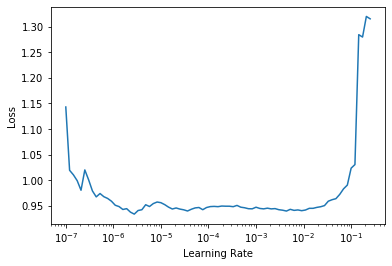

In [10]:
learn.lr_find()

In [11]:
learn.fit_one_cycle(1, 3e-3, wd=1e-2)

epoch,train_loss,valid_loss,vae_1,vae_2,vae_3,vae_4,vae_5,vae_6,time
0,0.789586,0.975548,0.589083,0.937419,1.000088,0.838296,1.120028,1.075449,09:28


In [12]:
dn_model = xresnet18_deconv(c_in=5, n_out=dls.c, sa=True, act_cls=MishCuda, groups=64, reduction=8)

learn = Learner(
    dls, 
    dn_model, 
    opt_func=ranger, 
    metrics=[vae_1, vae_2, vae_3, vae_4, vae_5, vae_6], 
    loss_func=root_mean_squared_error
)

learn.fit_one_cycle(1, 3e-3, wd=1e-3)

epoch,train_loss,valid_loss,vae_1,vae_2,vae_3,vae_4,vae_5,vae_6,time
0,0.792414,1.160816,0.982365,0.912374,1.104175,1.127900,1.202740,1.162978,09:43


In [13]:
dn_model = xresnet18_deconv(c_in=5, n_out=dls.c, sa=True, act_cls=MishCuda, groups=64, reduction=8)

learn = Learner(
    dls, 
    dn_model, 
    opt_func=ranger, 
    metrics=[vae_1, vae_2, vae_3, vae_4, vae_5, vae_6], 
    loss_func=root_mean_squared_error
)

learn.fit_one_cycle(1, 3e-4, wd=1e-2)

epoch,train_loss,valid_loss,vae_1,vae_2,vae_3,vae_4,vae_5,vae_6,time
0,0.868060,4.042886,3.242779,5.133075,3.013916,4.190418,3.319109,2.023038,09:47


In [18]:
dn_model = xresnet18_deconv(
    c_in=5, n_out=dls.c, sa=True, act_cls=MishCuda, groups=64, reduction=8, 
    stem_szs=[64, 64, 64]     # try big stem?
)

learn = Learner(
    dls, 
    dn_model, 
    opt_func=ranger, 
    metrics=[vae_1, vae_2, vae_3, vae_4, vae_5, vae_6], 
    loss_func=root_mean_squared_error
)

learn.fit_one_cycle(1, 3e-3, wd=1e-2)

epoch,train_loss,valid_loss,vae_1,vae_2,vae_3,vae_4,vae_5,vae_6,time
0,0.810098,1.132327,0.816212,1.269663,0.984283,1.292094,0.883795,1.122872,10:18


## Test hybrid model

SuggestedLRs(lr_min=0.0002511886414140463, lr_steep=2.2908675418875646e-06)

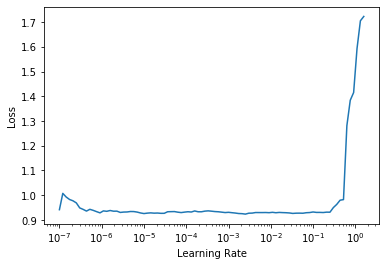

In [20]:
hybrid_model = xresnet18_hybrid(
    c_in=5, n_out=dls.c, sa=True, act_cls=MishCuda, groups=64, reduction=8)

learn = Learner(
    dls, 
    hybrid_model, 
    opt_func=ranger, 
    metrics=[vae_1, vae_2, vae_3, vae_4, vae_5, vae_6], 
    loss_func=root_mean_squared_error
)

learn.lr_find()

In [21]:
hybrid_model = xresnet18_hybrid(
    c_in=5, n_out=dls.c, sa=True, act_cls=MishCuda, groups=64, reduction=8)

learn = Learner(
    dls, 
    hybrid_model, 
    opt_func=ranger, 
    metrics=[vae_1, vae_2, vae_3, vae_4, vae_5, vae_6], 
    loss_func=root_mean_squared_error
)

learn.fit_one_cycle(1, 3e-2, wd=1e-2)

epoch,train_loss,valid_loss,vae_1,vae_2,vae_3,vae_4,vae_5,vae_6,time
0,0.801370,0.794347,0.521941,0.768840,0.854468,0.797766,0.824803,0.923069,05:45


# Comparisons for 10 epochs training

Note: batchsize is changed to 128 now

In [6]:
item_tfms = Resize(224)
batch_tfms = aug_transforms(max_zoom=1., flip_vert=True, max_lighting=0., max_warp=0.)+[Normalize]

dblock = DataBlock(
    blocks=(grizyImageBlock, RegressionBlock),
    get_x=ColReader(['SpecObjID'], pref=f'{PATH}/data/sdss_npy_images/', suff='.npy'),
    get_y=Pipeline([ColReader(label_cols, label_delim=None)]),
    splitter=RandomSplitter(0.2, seed=seed),
    item_tfms=item_tfms,
    batch_tfms=batch_tfms,
)

dls = ImageDataLoaders.from_dblock(dblock, gal, path=PATH, bs=128)

## Full deconv model

In [16]:
dn_model = xresnet18_deconv(c_in=5, n_out=dls.c, sa=True, act_cls=MishCuda, groups=64, reduction=8)

learn = Learner(
    dls, 
    dn_model, 
    opt_func=ranger, 
    metrics=[vae_1, vae_2, vae_3, vae_4, vae_5, vae_6], 
    loss_func=root_mean_squared_error
)

learn.fit_one_cycle(10, 3e-3, wd=1e-2)

epoch,train_loss,valid_loss,vae_1,vae_2,vae_3,vae_4,vae_5,vae_6,time
0,0.862328,10.362975,9.075419,15.026629,13.366401,6.033828,6.161248,3.386722,08:31
1,0.806331,4.009762,3.366370,7.145920,3.503191,2.819346,1.618552,1.751282,07:57
2,0.782025,0.899467,0.608608,0.845087,1.025429,0.845280,0.937942,0.938132,09:20
3,0.767137,2.048101,0.804300,0.994521,3.382150,1.466148,1.633206,2.330307,09:34
4,0.745198,1.421113,0.860484,1.209805,1.687517,1.277601,1.155256,1.637175,09:34
5,0.735076,0.897658,0.701423,0.848906,0.844954,0.796357,0.842043,1.082526,09:37
6,0.712315,0.774615,0.444419,0.722409,0.828150,0.764695,0.800548,0.949597,09:38
7,0.699338,0.777269,0.425280,0.780024,0.797516,0.756714,0.821663,0.925751,09:27
8,0.693634,0.731881,0.420689,0.701558,0.770966,0.746991,0.779577,0.865867,09:49
9,0.696956,0.735425,0.405937,0.720039,0.769223,0.752438,0.773373,0.873313,09:51


In [ ]:
# learn.save('sdss64k-xresnet18_deconv-neurips_10ep')

## Hybrid CNN model

In [7]:
hybrid_model = xresnet18_hybrid(c_in=5, n_out=dls.c, sa=True, act_cls=MishCuda, groups=64, reduction=8)

learn = Learner(
    dls, 
    hybrid_model, 
    opt_func=ranger, 
    metrics=[vae_1, vae_2, vae_3, vae_4, vae_5, vae_6], 
    loss_func=root_mean_squared_error
)

learn.fit_one_cycle(10, 3e-2, wd=1e-2)

epoch,train_loss,valid_loss,vae_1,vae_2,vae_3,vae_4,vae_5,vae_6,time
0,0.834827,0.920769,0.684037,0.947657,0.960865,0.863069,0.963145,1.041837,05:58
1,0.799671,0.853093,0.525888,0.873069,0.904299,0.798115,0.832086,1.067500,05:55
2,0.781178,0.787916,0.507234,0.759545,0.834439,0.814582,0.826043,0.890635,05:57
3,0.764441,0.788984,0.523212,0.796077,0.820850,0.799439,0.827123,0.899122,06:14
4,0.753542,0.763263,0.453244,0.728952,0.823914,0.776838,0.842860,0.863433,05:14
5,0.733992,0.735012,0.428107,0.714494,0.783496,0.763664,0.777286,0.853068,05:59
6,0.728890,0.734800,0.430246,0.707636,0.788455,0.756780,0.776574,0.858864,06:56
7,0.722811,0.725311,0.416083,0.699641,0.784696,0.751875,0.764208,0.843377,05:06
8,0.715512,0.713397,0.407116,0.689799,0.751287,0.745469,0.757341,0.837496,05:56
9,0.709389,0.711142,0.399777,0.684935,0.750159,0.744239,0.754347,0.838128,06:27


In [8]:
# learn.save('sdss64k-xresnet18_hybrid-neurips_10ep')

## Fully CNN model

In [9]:
cnn_model = xresnet18(c_in=5, n_out=dls.c, sa=True, act_cls=MishCuda, groups=64, reduction=8)

learn = Learner(
    dls, 
    cnn_model, 
    opt_func=ranger, 
    metrics=[vae_1, vae_2, vae_3, vae_4, vae_5, vae_6], 
    loss_func=root_mean_squared_error
)

learn.fit_one_cycle(10, 3e-2, wd=1e-2)

epoch,train_loss,valid_loss,vae_1,vae_2,vae_3,vae_4,vae_5,vae_6,time
0,0.831680,0.845491,0.595401,0.817392,0.929394,0.868533,0.856771,0.941851,05:38
1,0.791406,0.935910,0.691812,1.082978,0.908527,1.033629,0.882400,0.954349,05:38
2,0.780684,0.927254,1.078250,0.815388,0.895587,0.903002,0.871736,0.963856,06:21
3,0.755188,3.500164,1.439196,1.803372,5.222748,1.485770,5.543507,2.811966,05:30
4,0.748654,0.914911,0.862689,0.755321,1.113365,0.929511,0.869986,0.907248,05:55
5,0.737614,0.821540,0.711037,0.728189,0.820935,0.810145,0.939822,0.883075,06:11
6,0.726292,0.805818,0.535727,0.828963,0.821922,0.830307,0.811571,0.937056,06:28
7,0.716505,0.737307,0.459944,0.691608,0.777309,0.774425,0.792264,0.849437,05:41
8,0.704541,0.727229,0.416281,0.694882,0.775943,0.753893,0.775156,0.852649,06:01
9,0.702566,0.726489,0.407154,0.693771,0.781047,0.753177,0.771025,0.853817,06:46


In [10]:
# learn.save('sdss64k-xresnet18_cnn-neurips_10ep')

## Full deconv network with high LR

In [ ]:
dn_model = xresnet18_deconv(c_in=5, n_out=dls.c, sa=True, act_cls=MishCuda, groups=64, reduction=8)

learn = Learner(
    dls, 
    dn_model, 
    opt_func=ranger, 
    metrics=[vae_1, vae_2, vae_3, vae_4, vae_5, vae_6], 
    loss_func=root_mean_squared_error
)

learn.fit_one_cycle(10, 3e-2, wd=1e-2)

In [12]:
learn.save('sdss64k-xresnet18_deconv-neurips_10ep_highLR')

## Simple baseline CNN model

In [6]:
baseline_model = nn.Sequential(
    ConvLayer(5, 32, stride=2),
    ConvLayer(32, 32, stride=2),
    ConvLayer(32, 64),
    nn.AdaptiveAvgPool2d(1),
    Flatten(),
    nn.Linear(64, dls.c)
).cuda()

learn = Learner(
    dls, 
    baseline_model, 
    opt_func=ranger, 
    metrics=[vae_1, vae_2, vae_3, vae_4, vae_5, vae_6], 
    loss_func=root_mean_squared_error
)

learn.fit_one_cycle(10, 3e-2, wd=1e-2)

epoch,train_loss,valid_loss,vae_1,vae_2,vae_3,vae_4,vae_5,vae_6,time
0,0.902568,0.921372,0.921199,0.872583,0.912305,0.940784,0.897891,0.964360,06:09
1,0.896264,0.918121,0.890783,0.866608,0.936274,0.945966,0.888726,0.961019,10:16
2,0.899009,0.929069,0.939277,0.869597,0.914436,0.981241,0.890642,0.959253,10:17
3,0.894471,0.964029,1.086974,0.867051,0.918852,1.033813,0.885424,0.958176,08:52
4,0.882305,0.954399,1.052001,0.859916,0.915551,1.030307,0.883445,0.954579,06:44
5,0.887546,0.884265,0.782879,0.840520,0.909424,0.923949,0.869245,0.952963,06:04
6,0.876819,0.957781,1.066509,0.881137,0.907582,1.009157,0.897273,0.952504,07:20
7,0.870843,0.874652,0.753099,0.825566,0.904941,0.918592,0.864647,0.950578,05:03
8,0.865929,0.943138,0.895203,0.941348,0.918658,1.056391,0.867314,0.951802,06:22
9,0.865017,0.884892,0.789310,0.835406,0.908048,0.929801,0.863195,0.951153,07:12


Why does this take so long.

## Simple deconv-only model

In [8]:
baseline_deconv_model = nn.Sequential(
    FastDeconv(5, 32, 3, stride=2), nn.ReLU(),
    FastDeconv(32, 32, 3, stride=2), nn.ReLU(),
    FastDeconv(32, 64, 3), nn.ReLU(),
    nn.AdaptiveAvgPool2d(1),
    Flatten(),
    nn.Linear(64, dls.c)
).cuda()

learn = Learner(
    dls, 
    baseline_deconv_model, 
    opt_func=ranger, 
    metrics=[vae_1, vae_2, vae_3, vae_4, vae_5, vae_6], 
    loss_func=root_mean_squared_error
)

learn.fit_one_cycle(10, 3e-2, wd=1e-2)

epoch,train_loss,valid_loss,vae_1,vae_2,vae_3,vae_4,vae_5,vae_6,time
0,0.892172,0.992219,1.085405,0.951703,0.935743,1.033940,0.923834,0.961810,06:06
1,0.869880,0.896254,0.736474,0.851615,0.960002,0.938576,0.891297,0.951027,07:19
2,0.852987,0.851742,0.649903,0.817272,0.902233,0.873593,0.862699,0.952495,05:31
3,0.845514,0.853812,0.616528,0.801845,0.972603,0.876466,0.857008,0.933366,06:28
4,0.829292,0.840712,0.665631,0.782501,0.868347,0.859114,0.851888,0.925070,07:10
5,0.824357,0.844010,0.603365,0.823467,0.933530,0.877428,0.836513,0.922192,05:29
6,0.810332,0.830745,0.715986,0.775937,0.861281,0.835934,0.835674,0.925685,06:33
7,0.815292,0.835707,0.602565,0.798507,0.863204,0.869095,0.867779,0.934704,07:31
8,0.810316,0.813662,0.575099,0.781359,0.876817,0.825101,0.831371,0.921081,05:47
9,0.806404,0.823575,0.588313,0.799772,0.890257,0.836637,0.837375,0.920921,06:58


# Show results

In [50]:
def _get_VAE_model():
    sys.path.append('/home/jupyter/morphological-spectra/SDSS-VAE')
    VAE = torch.load(f'/home/jupyter/morphological-spectra/SDSS-VAE/64k_20190612/0057.pth').eval()
    return VAE

def _get_latent_PCA_model():
    with open(f'/home/jupyter/morphological-spectra/SDSS-VAE/latent_pca.pkl', 'rb') as f:
        latent_PCA = pickle.load(f)
    return latent_PCA

def _get_meanspec():
    return np.load('/home/jupyter/morphological-spectra/SDSS-VAE/meanspec.npy')

def norm(vals, vmin=None, vmax=None, Q=8, stretch=None):
    """
    For visualization purposes normalize image with `arcsinh((vals-vmin)/(vmax-vmin)), 
    with vals either specified or within 0.01 and 0.99 quantiles of all values. 
    
    Q and stretch control the arcsinh softening parameter, see Lupton et al. 2004 and
    see https://docs.astropy.org/en/stable/_modules/astropy/visualization/lupton_rgb.html#make_lupton_rgb
    """
    vmin = ifnone(vmin, np.quantile(vals, 0.01))
    vmax = ifnone(vmax, np.quantile(vals, 0.99))
    
    if stretch is None:
        return np.arcsinh(Q*(vals - vmin) / (vmax-vmin)) / Q
    else:
        return np.arcsinh(Q*(vals - vmin) / stretch) / Q

def show_composite(img, ax=None, figsize=(3,3), title=None, scale=True,
                   ctx=None, vmin=None, vmax=None, stretch=None, **kwargs)->plt.Axes:
    "Show three channel composite so that channels correspond to grizy"
    ax = ifnone(ax, ctx)
    if ax is None: _, ax = plt.subplots(figsize=figsize)    
    tempim = img.data.cpu().numpy()
    im = np.zeros((tempim.shape[1], tempim.shape[2], 3))
    im[...,0] = np.mean([tempim[0], 0.5*tempim[1]], axis=0) 
    im[...,1] = np.mean([0.5*tempim[1], tempim[2]], axis=0)
    im[...,2] = np.mean([tempim[3], tempim[4]], axis=0)
    if scale: im = norm(im, vmin, vmax, stretch=stretch)
    ax.imshow(np.clip(im, 0, 1), **kwargs)
    ax.axis('off')
    if title is not None: ax.set_title(title)
    return ax

def show_decoded_results(
    dls, cnn_model, vmin=vmin, vmax=vmax, Q=8, stretch=None,
    latent_PCA=None, VAE=None, meanspec=None, 
    ncols=4, nrows=1, dpi=100, scale=True
):
    
    assert dls.bs > ncols*nrows, "You're requesting more plots than can fit in a single batch!"
    x, y = dls.one_batch()    
    p = cnn_model(x)
    
    latent_PCA = ifnone(latent_PCA, _get_latent_PCA_model())
    VAE = ifnone(VAE, _get_VAE_model())
    meanspec = ifnone(meanspec, _get_meanspec())
    
    x, y, p = x.detach(), y.detach(), p.detach()

    idxs = np.random.choice(range(dls.bs), size=nrows*ncols, replace=False)

    # figure
    fig = plt.figure(figsize=(5*ncols, 6*nrows), dpi=dpi)
    gs = matplotlib.gridspec.GridSpec(2*nrows, ncols, height_ratios=nrows*[0.8, 5]) 


    for i, idx in enumerate(idxs):
        with torch.no_grad():
            p_recon = VAE.decode(torch.tensor(latent_PCA.inverse_transform(p[idx].cpu()), dtype=torch.float32)).numpy() + meanspec
            y_recon = VAE.decode(torch.tensor(latent_PCA.inverse_transform(y[idx].cpu()), dtype=torch.float32)).numpy() + meanspec
        
        spec_idx = i + (ncols) * (i//ncols)
        im_idx = i+ncols + (ncols)*(i//ncols)
        
        ax_spec = plt.subplot(gs[spec_idx])
        ax_spec.plot(y_recon, c='k', lw=1)
        ax_spec.plot(p_recon, c='C3')
        ax_spec.set_ylim(*np.quantile(p_recon, [0.01, 0.99]))
        ax_spec.axis('off')

        ax_im = plt.subplot(gs[im_idx])
        show_composite(x[idx], ax=ax_im, vmin=vmin, vmax=vmax)
        
    return fig, fig.get_axes()

In [14]:
hybrid_model = xresnet18_hybrid(c_in=5, n_out=dls.c, sa=True, act_cls=MishCuda, groups=64, reduction=8)

learn = Learner(
    dls, 
    hybrid_model, 
    opt_func=ranger, 
    loss_func=root_mean_squared_error
)

learn = learn.load('sdss64k-xresnet18_hybrid-neurips_10ep');

In [15]:
xb, yb = learn.dls.one_batch()
xb, yb = xb.cpu(), yb.cpu()

In [28]:
vmin, vmax = np.quantile(xb.data, q=[0.02, 0.98])
vmin, vmax

(-0.2780773305892944, 0.4194131290912626)

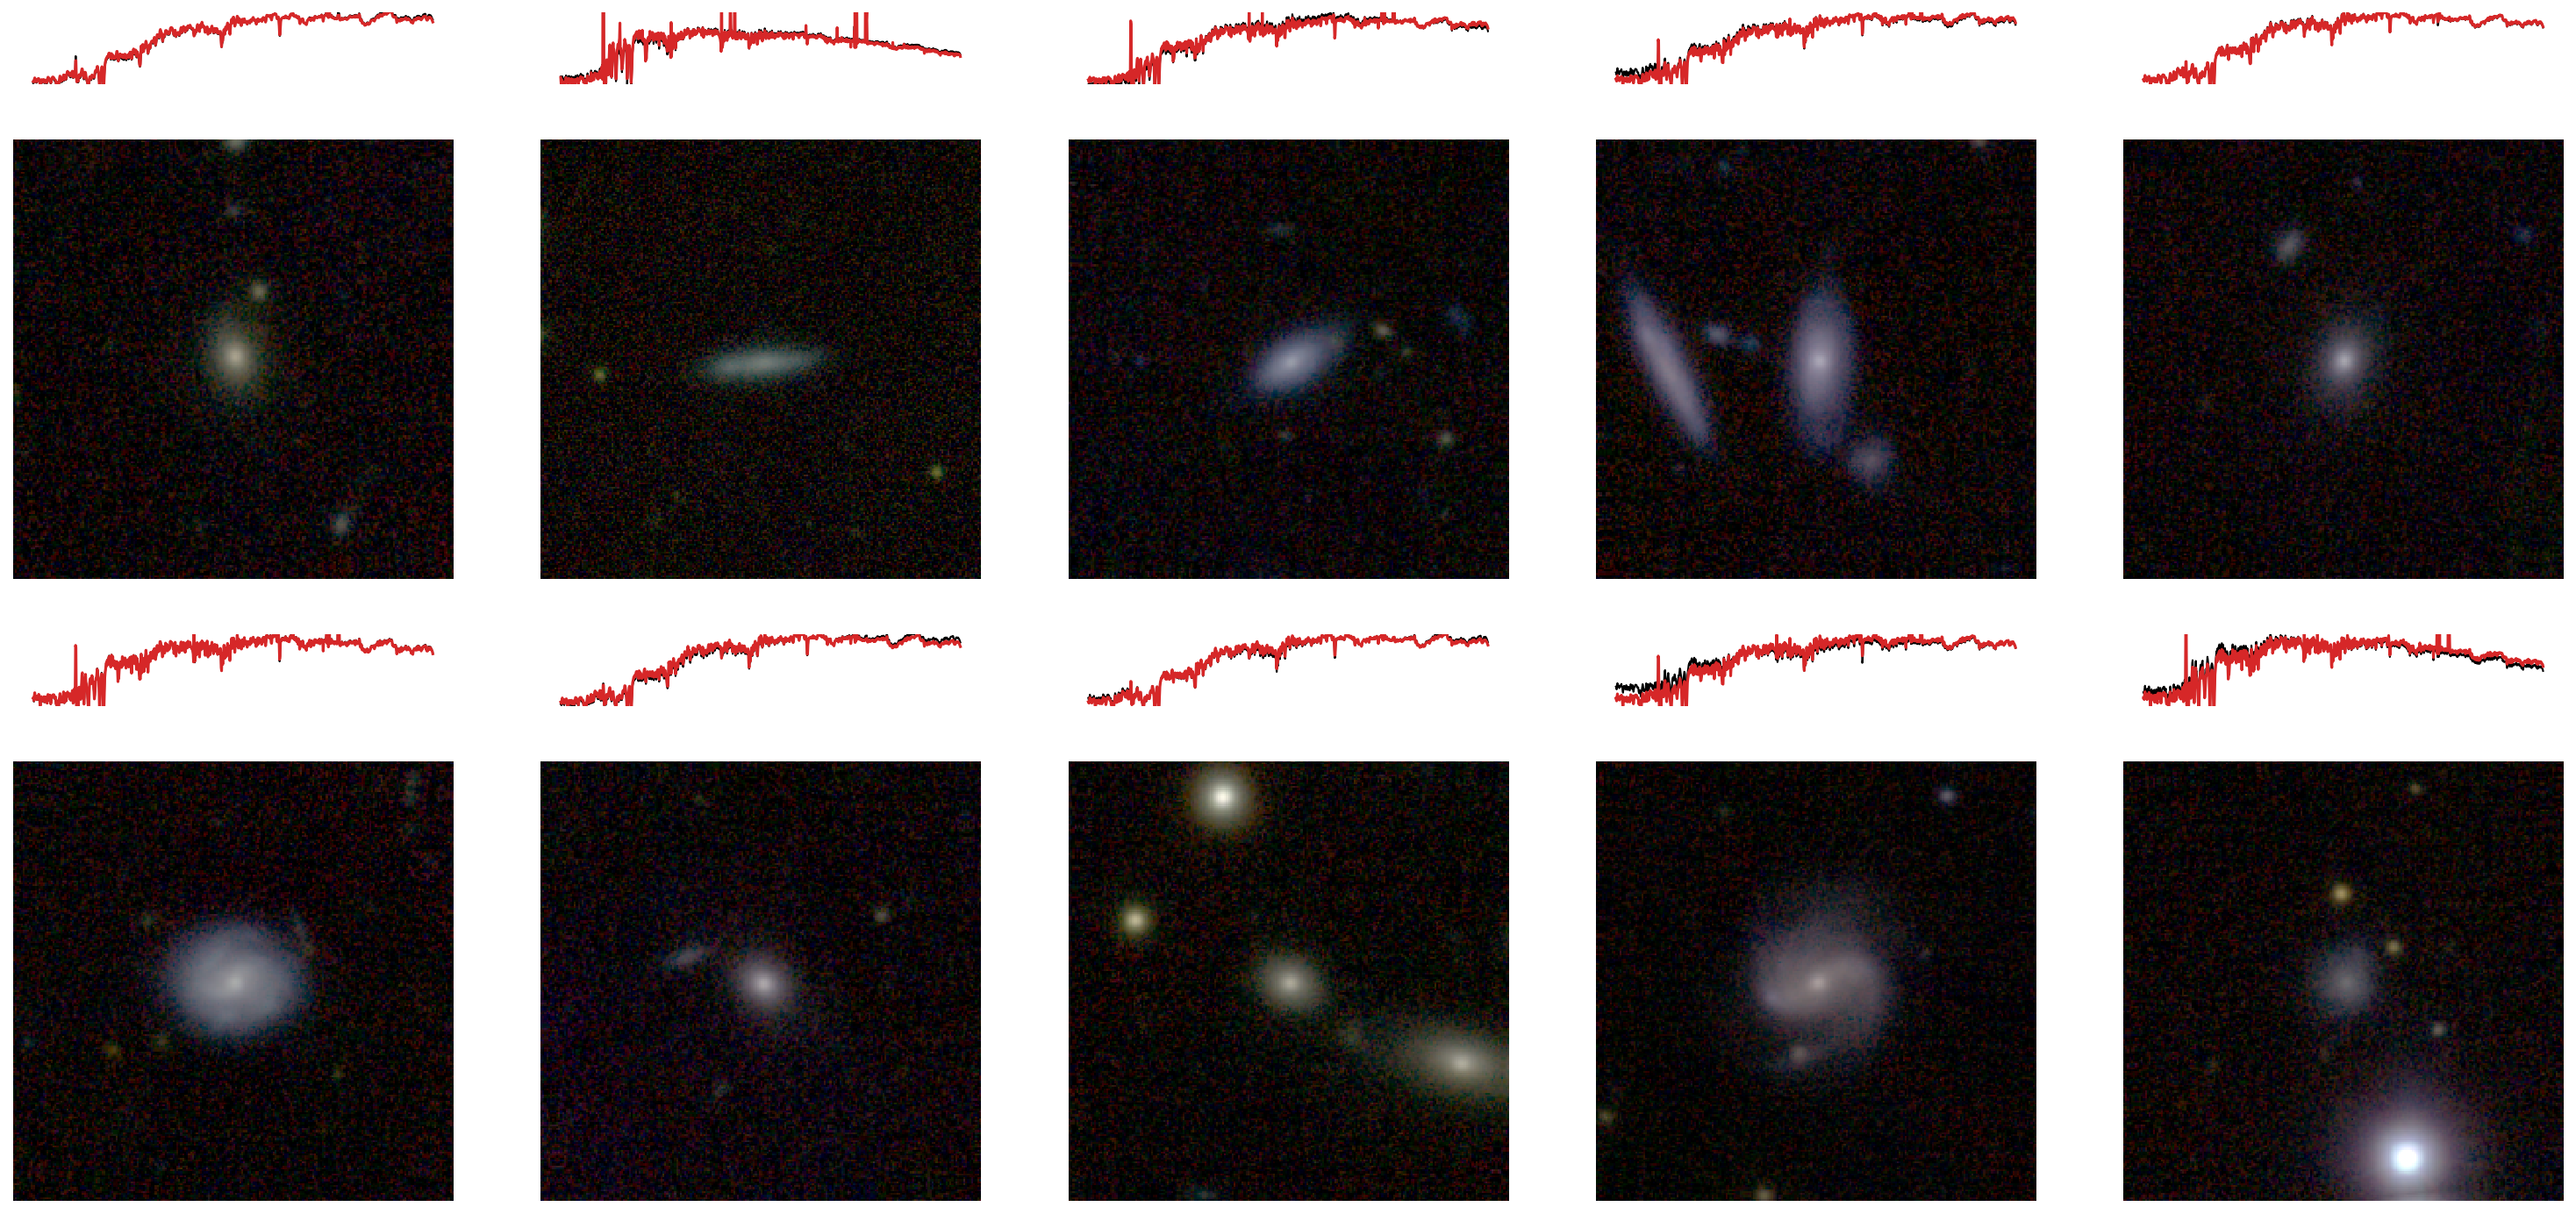

In [61]:
show_decoded_results(
    learn.dls, 
    learn.model, 
    Q=20,
    nrows=2,
    ncols=5,
    vmin=-0.05, 
    vmax=0.5,
    dpi=150,
);

## Number of model params

In [65]:
hybrid_model = xresnet18_hybrid(c_in=5, n_out=dls.c, sa=True, act_cls=MishCuda, groups=64, reduction=8)
sum(p.numel() for p in hybrid_model.parameters() if p.requires_grad)

6734743

In [63]:
cnn_model = xresnet18(c_in=5, n_out=dls.c, sa=True, act_cls=MishCuda, groups=64, reduction=8)
sum(p.numel() for p in cnn_model.parameters() if p.requires_grad)

6734871

In [64]:
dn_model = xresnet18_deconv(c_in=5, n_out=dls.c, sa=True, act_cls=MishCuda, groups=64, reduction=8)
sum(p.numel() for p in dn_model.parameters() if p.requires_grad)

6730007

In [67]:
baseline_model = nn.Sequential(
    ConvLayer(5, 32, stride=2),
    ConvLayer(32, 32, stride=2),
    ConvLayer(32, 64),
    nn.AdaptiveAvgPool2d(1),
    Flatten(),
    nn.Linear(64, dls.c)
)

sum(p.numel() for p in baseline_model.parameters() if p.requires_grad)

29734

In [66]:
baseline_deconv_model = nn.Sequential(
    FastDeconv(5, 32, 3, stride=2), nn.ReLU(),
    FastDeconv(32, 32, 3, stride=2), nn.ReLU(),
    FastDeconv(32, 64, 3), nn.ReLU(),
    nn.AdaptiveAvgPool2d(1),
    Flatten(),
    nn.Linear(64, dls.c)
)

sum(p.numel() for p in baseline_deconv_model.parameters() if p.requires_grad)

29606

# Models without Mish, SA, or Ranger

In [68]:
hybrid_model = xresnet18_hybrid(c_in=5, n_out=dls.c, groups=64, reduction=8)

learn = Learner(
    dls, 
    hybrid_model, 
    metrics=[vae_1, vae_2, vae_3, vae_4, vae_5, vae_6], 
    loss_func=root_mean_squared_error
)

learn.fit_one_cycle(10, 3e-2, wd=1e-2)

epoch,train_loss,valid_loss,vae_1,vae_2,vae_3,vae_4,vae_5,vae_6,time
0,0.828847,0.854842,0.638576,0.815654,0.923434,0.860986,0.852463,0.962184,13:22
1,0.791734,0.807683,0.579753,0.763477,0.867562,0.807211,0.834158,0.932667,10:51
2,0.786191,0.798413,0.540601,0.782635,0.854339,0.794782,0.865819,0.886519,10:31
3,0.760415,0.827922,0.603077,0.779957,0.840206,0.836511,0.887491,0.949035,10:34
4,0.753518,0.765030,0.469526,0.740835,0.820545,0.770072,0.802282,0.899349,10:07
5,0.750284,0.760758,0.485912,0.726664,0.807189,0.770324,0.812763,0.868567,07:54
6,0.735567,0.757701,0.454402,0.758256,0.821155,0.774609,0.788820,0.862841,06:46
7,0.728130,0.727616,0.416683,0.700413,0.777917,0.758368,0.767274,0.850864,07:23
8,0.715242,0.720476,0.408975,0.692773,0.766439,0.749160,0.762185,0.848579,07:06
9,0.710556,0.718818,0.407849,0.691986,0.765587,0.748905,0.758753,0.845649,06:40


# Weighted loss depending on VAE components

In [87]:
# want to more highly weight VAE1
weights = 1./tensor([0.41, 0.69, 0.76, 0.75, 0.76, 0.84]).cuda()

def weighted_rmse(preds, targs, weights=weights): 
    return ((preds - targs)**2 * weights.expand_as(targs)).mean()**0.5

In [88]:
hybrid_model = xresnet18_hybrid(c_in=5, n_out=dls.c, groups=64, reduction=8)

learn = Learner(
    dls, 
    hybrid_model, 
    metrics=[vae_1, vae_2, vae_3, vae_4, vae_5, vae_6], 
    loss_func=weighted_rmse
)

learn.fit_one_cycle(10, 3e-2, wd=1e-2)

epoch,train_loss,valid_loss,vae_1,vae_2,vae_3,vae_4,vae_5,vae_6,time
0,0.983595,1.028950,0.630017,0.861376,0.914402,0.896104,0.849191,0.975343,06:49
1,0.943329,0.996559,0.557227,0.851315,0.867795,0.862948,0.923050,0.922735,06:15
2,0.917907,0.983360,0.584207,0.781226,0.932638,0.812924,0.826161,0.964460,06:54
3,0.901859,0.986161,0.648305,0.807992,0.868548,0.804621,0.887134,0.890517,07:25
4,0.887841,0.907281,0.481722,0.748413,0.810272,0.815853,0.811796,0.876575,07:13
5,0.878604,0.927693,0.549431,0.739583,0.856248,0.791333,0.811161,0.882647,07:28
6,0.867600,0.860574,0.424774,0.708085,0.779717,0.762009,0.772341,0.865615,07:37
7,0.846892,0.850756,0.408979,0.700873,0.775656,0.755421,0.766392,0.855439,07:36
8,0.834866,0.835192,0.394878,0.689759,0.753230,0.745621,0.757212,0.844592,07:33
9,0.826360,0.835028,0.396224,0.686283,0.755048,0.745135,0.757476,0.844212,07:46


# Training for 50 epochs

In [5]:
item_tfms = Resize(224)
batch_tfms = aug_transforms(max_zoom=1., flip_vert=True, max_lighting=0., max_warp=0.)+[Normalize]

dblock = DataBlock(
    blocks=(grizyImageBlock, RegressionBlock),
    get_x=ColReader(['SpecObjID'], pref=f'{PATH}/data/sdss_npy_images/', suff='.npy'),
    get_y=Pipeline([ColReader(label_cols, label_delim=None)]),
    splitter=RandomSplitter(0.2, seed=seed),
    item_tfms=item_tfms,
    batch_tfms=batch_tfms,
)

dls = ImageDataLoaders.from_dblock(dblock, gal, path=PATH, bs=128)

In [6]:
hybrid_model = xresnet18_hybrid(c_in=5, n_out=dls.c, sa=True, act_cls=MishCuda, groups=64, reduction=8)

learn = Learner(
    dls, 
    hybrid_model, 
    opt_func=ranger, 
    metrics=[vae_1, vae_2, vae_3, vae_4, vae_5, vae_6], 
    loss_func=root_mean_squared_error
)

learn.fit_one_cycle(50, 3e-2, wd=1e-2)

epoch,train_loss,valid_loss,vae_1,vae_2,vae_3,vae_4,vae_5,vae_6,time
0,0.871066,0.879736,0.612144,0.899001,0.924816,0.921178,0.876483,0.958746,07:01
1,0.794924,0.820404,0.544253,0.795395,0.924740,0.822421,0.818172,0.928376,07:04
2,0.771430,0.771040,0.506003,0.749320,0.819784,0.791878,0.807126,0.878539,07:16
3,0.760865,0.800041,0.514975,0.862426,0.865141,0.786408,0.789901,0.902586,07:10
4,0.758057,0.833767,0.572769,0.748502,0.948406,0.864078,0.863525,0.906045,07:05
5,0.753887,0.758251,0.460279,0.748804,0.810295,0.774449,0.793943,0.876927,07:33
6,0.755215,0.848137,0.691248,0.790166,0.870376,0.866610,0.899742,0.922966,07:01
7,0.742555,0.909972,0.666352,0.748427,0.943874,0.992744,0.869915,1.102219,06:58
8,0.738559,0.758299,0.447861,0.712423,0.814898,0.788504,0.807237,0.876956,07:18
9,0.753925,0.760345,0.523655,0.730780,0.787445,0.779622,0.790365,0.887282,07:17


In [7]:
dn_model = xresnet18_deconv(c_in=5, n_out=dls.c, sa=True, act_cls=MishCuda, groups=64, reduction=8)

learn = Learner(
    dls, 
    dn_model, 
    opt_func=ranger, 
    metrics=[vae_1, vae_2, vae_3, vae_4, vae_5, vae_6], 
    loss_func=root_mean_squared_error
)

learn.fit_one_cycle(50, 3e-3, wd=1e-2)

epoch,train_loss,valid_loss,vae_1,vae_2,vae_3,vae_4,vae_5,vae_6,time
0,0.904471,1.685797,1.333430,1.893703,1.844987,1.276627,1.228702,1.778272,07:17
1,0.839762,0.942001,0.633637,0.882772,1.040817,0.866894,0.984967,1.104045,06:57
2,0.803344,0.848194,0.553093,0.813780,0.911967,0.876760,0.870319,0.930855,06:28
3,0.776436,0.789565,0.506561,0.758030,0.853051,0.803189,0.833024,0.900541,06:41
4,0.765090,1.236560,0.938779,1.083035,1.160139,1.095622,1.001693,1.710029,06:35
5,0.755915,1.776410,1.592269,1.025904,2.424870,1.611641,1.823023,1.418819,07:31
6,0.744274,1.222593,0.665412,1.625122,1.062612,1.092112,1.203941,1.211680,06:43
7,0.746338,0.760437,0.524302,0.731049,0.806271,0.783061,0.781280,0.875059,06:26
8,0.737326,1.713222,0.740393,0.907685,0.985748,1.569899,2.955340,1.473209,06:59
9,0.731338,1.431356,1.235423,1.194790,1.155601,1.742667,1.280450,1.592414,06:37


In [8]:
cnn_model = xresnet18(c_in=5, n_out=dls.c, sa=True, act_cls=MishCuda, groups=64, reduction=8)

learn = Learner(
    dls, 
    cnn_model, 
    opt_func=ranger, 
    metrics=[vae_1, vae_2, vae_3, vae_4, vae_5, vae_6], 
    loss_func=root_mean_squared_error
)

learn.fit_one_cycle(50, 3e-2, wd=1e-2)

epoch,train_loss,valid_loss,vae_1,vae_2,vae_3,vae_4,vae_5,vae_6,time
0,0.869616,0.864897,0.621175,0.873028,0.907472,0.910906,0.861351,0.955511,09:56
1,0.800591,0.807864,0.523241,0.786096,0.879485,0.814872,0.832189,0.927227,09:55
2,0.765520,0.782305,0.481836,0.786852,0.853712,0.800454,0.817130,0.873438,09:48
3,0.762241,0.811415,0.591485,0.792021,0.826236,0.851258,0.833156,0.922776,09:57
4,0.751762,1.152864,1.345139,0.906589,1.278213,1.151837,1.209660,0.946265,10:16
5,0.752439,0.779210,0.540036,0.736254,0.814207,0.798712,0.797987,0.922228,10:14
6,0.753700,0.832595,0.586845,0.814428,0.864596,0.854052,0.862422,0.953367,10:09
7,0.741026,1.299609,0.917035,1.453649,1.693447,1.332932,1.093526,1.141933,10:24
8,0.747326,0.844798,0.553649,0.920493,0.889112,0.873217,0.841480,0.917287,10:37
9,0.738204,0.878904,0.960705,0.781832,0.852813,0.858371,0.884353,0.912275,10:33


In [9]:
learn.save('sdss64k-xresnet18_cnn-neurips_50ep')